In [1]:
! pip install duckdb

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

In [3]:
import duckdb

In [68]:
transactions = duckdb.sql(
    """
SELECT
    *,
    CASE 
        WHEN country_of_purchase='China' THEN 'Asia Pacific'
        WHEN country_of_purchase='France' THEN 'Europe'
        WHEN country_of_purchase='USA' THEN 'Americas'
        WHEN country_of_purchase='Switzerland' THEN 'Europe'
        WHEN country_of_purchase='Japan' THEN 'Asia Pacific'
        WHEN country_of_purchase='Macau SAR, China' THEN 'Asia Pacific'
        WHEN country_of_purchase='Hong Kong SAR, China' THEN 'Asia Pacific'
        WHEN country_of_purchase='South Korea' THEN 'Asia Pacific'
        WHEN country_of_purchase='United Kingdom' THEN 'Europe'
        WHEN country_of_purchase='Russian Fed,' THEN 'Europe'
        WHEN country_of_purchase='Thailand' THEN 'Asia Pacific'
        WHEN country_of_purchase='Italy' THEN 'Europe'
        WHEN country_of_purchase='Utd,Arab Emir,' THEN 'Middle East & Africa'
        WHEN country_of_purchase='Taiwan, China' THEN 'Asia Pacific'
        WHEN country_of_purchase='Brazil' THEN 'Americas'
        WHEN country_of_purchase='Malaysia' THEN 'Asia Pacific'
        WHEN country_of_purchase='Singapore' THEN 'Asia Pacific'
        WHEN country_of_purchase='Germany' THEN'Europe'
        WHEN country_of_purchase='Spain' THEN 'Europe'
        WHEN country_of_purchase='Mexico' THEN 'Americas'
        WHEN country_of_purchase='Turkey' THEN 'Middle East & Africa'
        WHEN country_of_purchase='Canada' THEN'Americas'
        ELSE 'Other'
    END as region_of_purchase
FROM read_csv('../data/transactions.csv')
"""
)

In [47]:
transactions

┌────────────────────┬──────────────────┬───┬──────────────────┬────────────────────┬──────────────────────┐
│     client_id      │ transaction_date │ … │    price_full    │ product_collection │  region_of_purchase  │
│      varchar       │       date       │   │      double      │      varchar       │       varchar        │
├────────────────────┼──────────────────┼───┼──────────────────┼────────────────────┼──────────────────────┤
│ 0011i00000SzBVHAA3 │ 2017-04-10       │ … │ 10121.0147819178 │ Collection 6       │ Asia Pacific         │
│ 0011i00000SydhuAAB │ 2015-09-18       │ … │ 3591.17458743828 │ Collection 6       │ Asia Pacific         │
│ 0011i00000Sydm4AAB │ 2015-03-31       │ … │ 7310.30751894496 │ Collection 6       │ Asia Pacific         │
│ 0011i00000SydiFAAR │ 2015-10-09       │ … │ 9487.76878457763 │ Collection 8       │ Asia Pacific         │
│ 0011i00000SycixAAB │ 2015-03-26       │ … │ 27987.3169013564 │ Collection 6       │ Asia Pacific         │
│ 0011i00000SyfpHAA

In [64]:
transactions.df().to_gbq("richemont.transactions")

100%|██████████| 1/1 [00:00<00:00, 1960.87it/s]


In [7]:
transactions.aggregate("COUNT(DISTINCT client_id)")

┌───────────────────────────┐
│ count(DISTINCT client_id) │
│           int64           │
├───────────────────────────┤
│                     52855 │
└───────────────────────────┘

In [11]:
transactions.aggregate("CAST(SUM(price_full) AS INT) / 1e6")

┌────────────────────────────────────────────────┐
│ (CAST(sum(price_full) AS INTEGER) / 1000000.0) │
│                     double                     │
├────────────────────────────────────────────────┤
│                                     634.390623 │
└────────────────────────────────────────────────┘

In [31]:
duckdb.sql(
    """
    --- assumption: 2 transactions in the same day in the same country = one only transactions
WITH daily_transactions AS (
    SELECT
        client_id,
        transaction_date,
        country_of_purchase,
        gender,
        SUM(price_full) AS total_sales
    FROM transactions
    GROUP BY 1,2,3,4
),
time_delta AS (
SELECT 
    client_id,
    transaction_date,
    DATE_DIFF(
            'day', 
            transaction_date, 
            LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date)
            ) AS time_before_second_purchase
FROM daily_transactions
GROUP BY client_id, transaction_date
QUALIFY ROW_NUMBER() OVER (PARTITION BY client_id ORDER BY transaction_date) = 1
)
SELECT CAST(AVG(time_before_second_purchase) AS INT) AS avg_time_before_second_purchase FROM time_delta
           """
)

┌─────────────────────────────────┐
│ avg_time_before_second_purchase │
│              int32              │
├─────────────────────────────────┤
│                             213 │
└─────────────────────────────────┘

In [32]:
duckdb.sql(
    """
    --- assumption: 2 transactions in the same day in the same country = one only transactions
WITH daily_transactions AS (
    SELECT
        client_id,
        transaction_date,
        country_of_purchase,
        gender,
        SUM(price_full) AS total_sales
    FROM transactions
    GROUP BY 1,2,3,4
),
time_delta AS (
SELECT 
    client_id,
    transaction_date,
    DATE_DIFF(
            'day', 
            transaction_date, 
            LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date)
            ) AS time_before_next_purchase
FROM daily_transactions
GROUP BY client_id, transaction_date
QUALIFY ROW_NUMBER() OVER (PARTITION BY client_id ORDER BY transaction_date) > 1
)
SELECT CAST(AVG(time_before_next_purchase) AS INT) AS avg_time_before_next_purchase FROM time_delta
           """
)

┌───────────────────────────────┐
│ avg_time_before_next_purchase │
│             int32             │
├───────────────────────────────┤
│                           138 │
└───────────────────────────────┘

In [28]:
duckdb.sql(
    """
    --- assumption: 2 transactions in the same day in the same country = one only transactions
WITH daily_transactions AS (
    SELECT
        client_id,
        transaction_date,
        country_of_purchase,
        gender,
        SUM(price_full) AS total_sales
    FROM transactions
    GROUP BY 1,2,3,4
),
transactions_agg AS (
SELECT 
    client_id,
    COUNT(DISTINCT transaction_date) AS n_transactions,
FROM daily_transactions
GROUP BY client_id
)
SELECT ROUND(AVG(n_transactions), 2) AS avg_transactions_per_client FROM transactions_agg
           """
)

┌─────────────────────────────┐
│ avg_transactions_per_client │
│           double            │
├─────────────────────────────┤
│                        1.09 │
└─────────────────────────────┘

In [29]:
duckdb.sql(
    """
    --- assumption: 2 transactions in the same day in the same country = one only transactions
WITH daily_transactions AS (
    SELECT
        client_id,
        transaction_date,
        country_of_purchase,
        gender,
        SUM(price_full) AS total_sales
    FROM transactions
    GROUP BY 1,2,3,4
),
transactions_agg AS (
SELECT 
    *
FROM daily_transactions
)
SELECT AVG(total_sales) AS avg_transaction_price FROM transactions_agg
           """
)

┌───────────────────────┐
│ avg_transaction_price │
│        double         │
├───────────────────────┤
│     11033.64795269944 │
└───────────────────────┘

In [50]:
duckdb.sql(
    """
--- assumption: 2 transactions in the same day in the same country = one only transactions
WITH daily_transactions AS (
    SELECT
        client_id,
        transaction_date,
        country_of_purchase,
        region_of_purchase,
        gender,
        SUM(price_full) AS total_sales
    FROM transactions
    GROUP BY 1,2,3,4,5
)

SELECT 
    country_of_purchase,
    region_of_purchase,
    DATE_TRUNC('month', transaction_date),
    SUM(total_sales) AS total_sales
FROM daily_transactions
GROUP BY 1,2,3
"""
).df().to_clipboard()

In [63]:
duckdb.sql(
    """
SELECT 
    region_of_purchase AS 'Region',
    product_collection AS 'Collection',
    COUNT(1) AS 'Total sold',
    MIN(price_full) AS 'min_price',
    CAST(AVG(price_full) AS INT) AS 'avg_price',
    CAST(MAX(price_full) AS INT) AS 'max_price',
FROM transactions
GROUP BY 1,2
"""
).df()  # .to_gbq("richemont.products", if_exists="replace")

,Region,Collection,Total sold,min_price,avg_price,max_price
0,Middle East & Africa,Collection 2,991,1547.721955,8361,39278
1,Europe,Collection 6,1706,2689.339888,9044,338869
2,Europe,Collection 4,1601,2174.472712,7596,42029
3,Middle East & Africa,Collection 4,450,1275.437852,8105,45351
4,Europe,Collection 2,2417,3232.451096,6838,35502
5,Middle East & Africa,Collection 6,27,4879.343719,11871,33282
6,Americas,Collection 5,517,3430.414830,17454,373766
7,Asia Pacific,Collection 5,4559,4336.909940,16449,1442532
8,Americas,Collection 3,700,3398.732434,14141,126797
9,Americas,Collection 1,1933,2305.695041,10131,144921


<Axes: xlabel='nb_transactions'>

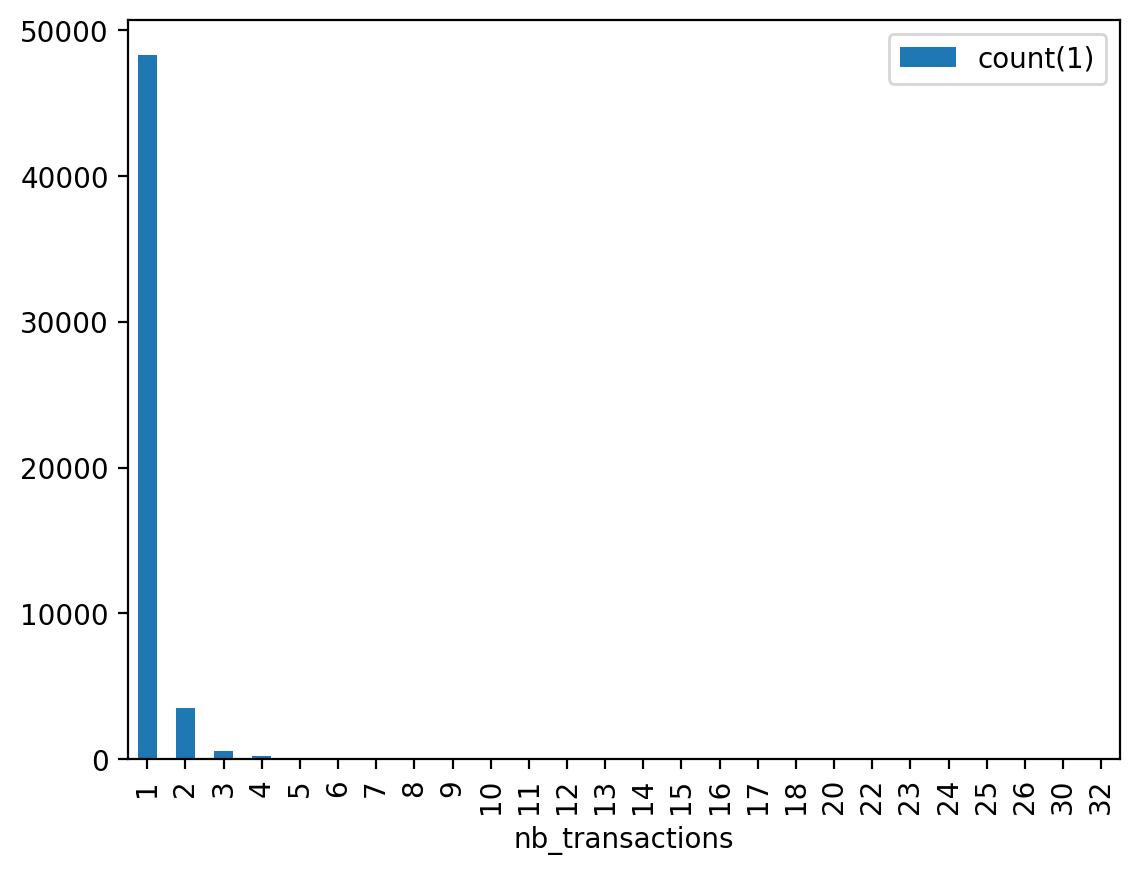

In [45]:
conn.sql(
    """
WITH nb_transactions AS (
    SELECT
        client_id,
        COUNT(1) AS nb_transactions
    FROM transactions
    GROUP BY 1
)

SELECT 
    nb_transactions,
    COUNT(1)
FROM nb_transactions
GROUP BY 1
ORDER BY nb_transactions
"""
).df().plot(x="nb_transactions", kind="bar")

In [10]:
conn.sql(
    """
WITH client_repurchase AS (
    SELECT
        client_id,
        COUNT(1) > 1 AS has_repurchased
    FROM transactions
    GROUP BY 1
)

SELECT 
    has_repurchased,
    COUNT(1) / SUM(COUNT(1)) OVER() * 100 AS perc_of_total
FROM client_repurchase
GROUP BY 1
ORDER BY has_repurchased
"""
)

┌─────────────────┬───────────────────┐
│ has_repurchased │   perc_of_total   │
│     boolean     │      double       │
├─────────────────┼───────────────────┤
│ false           │ 91.41235455491439 │
│ true            │ 8.587645445085613 │
└─────────────────┴───────────────────┘

In [68]:
query = """
SELECT 
    client_id, 
    transaction_date,
    gender,
    country_of_purchase AS country,
    product_collection AS product,
    LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date) as next_transaction_date,
    DATE_DIFF('day', transaction_date, LEAD(transaction_date) OVER (PARTITION BY client_id ORDER BY transaction_date)) AS date_diff_between_purchases,
    ROW_NUMBER() OVER (PARTITION BY client_id ORDER BY transaction_date) AS purchase_number
FROM transactions
QUALIFY COUNT(1) OVER (PARTITION BY client_id) > 1
"""

next_purchase = conn.sql(query)
next_purchase

┌────────────────────┬──────────────────┬─────────┬───┬──────────────────────┬──────────────────────┬─────────────────┐
│     client_id      │ transaction_date │ gender  │ … │ next_transaction_d…  │ date_diff_between_…  │ purchase_number │
│      varchar       │       date       │ varchar │   │         date         │        int64         │      int64      │
├────────────────────┼──────────────────┼─────────┼───┼──────────────────────┼──────────────────────┼─────────────────┤
│ 0011i00000S5dSyAAJ │ 2016-05-27       │ Female  │ … │ 2016-10-27           │                  153 │               1 │
│ 0011i00000S5dSyAAJ │ 2016-10-27       │ Female  │ … │ 2017-09-05           │                  313 │               2 │
│ 0011i00000S5dSyAAJ │ 2017-09-05       │ Female  │ … │ NULL                 │                 NULL │               3 │
│ 0011i00000S5dsDAAR │ 2016-11-30       │ Male    │ … │ 2017-04-05           │                  126 │               1 │
│ 0011i00000S5dsDAAR │ 2017-04-05       

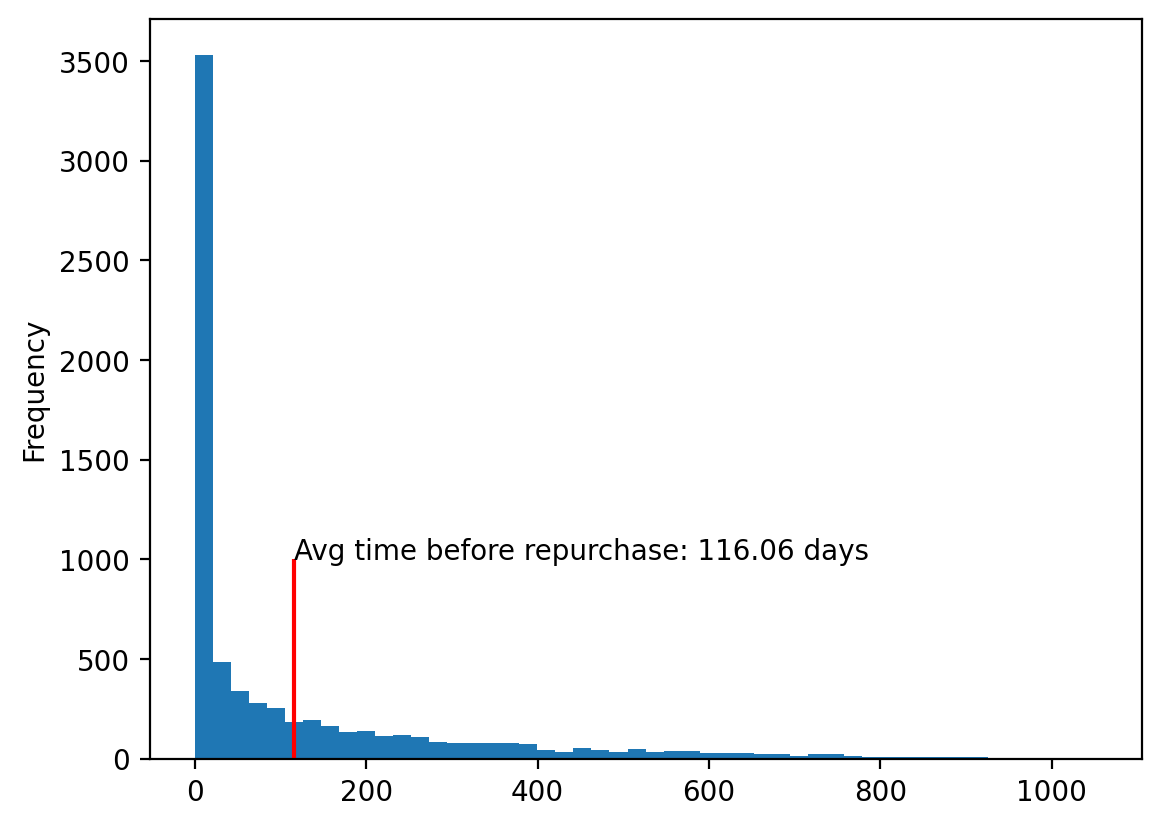

In [67]:
next_purchase_df = next_purchase.df()

mean_time_before_repurchase = next_purchase_df.date_diff_between_purchases.mean()

next_purchase_df.date_diff_between_purchases.plot.hist(bins=50)
plt.vlines(x=mean_time_before_repurchase, ymin=0, ymax=1000, colors="r")
plt.annotate(
    f"Avg time before repurchase: {mean_time_before_repurchase:.2f} days",
    (mean_time_before_repurchase, 1000),
)
plt.show()

In [73]:
query = """
SELECT 
    country,
    AVG(date_diff_between_purchases) AS avg_time_before_purchase,
    COUNT(DISTINCT client_id) AS nb_distinct_client
FROM next_purchase
GROUP BY 1
ORDER BY 2 DESC
-- QUALIFY COUNT(1) OVER (PARTITION BY client_id) > 1
"""

avg_time_before_purchase = conn.sql(query)
avg_time_before_purchase

┌──────────────────────┬──────────────────────────┬────────────────────┐
│       country        │ avg_time_before_purchase │ nb_distinct_client │
│       varchar        │          double          │       int64        │
├──────────────────────┼──────────────────────────┼────────────────────┤
│ Taiwan, China        │                   159.38 │                188 │
│ South Korea          │       151.87018544935805 │                469 │
│ Brazil               │                    148.0 │                 65 │
│ Malaysia             │                   145.75 │                 21 │
│ Germany              │       143.28169014084506 │                 53 │
│ USA                  │        141.3439226519337 │                520 │
│ Utd,Arab Emir,       │       138.93058568329718 │                272 │
│ Russian Fed,         │       132.05913978494624 │                 85 │
│ Switzerland          │         128.867816091954 │                137 │
│ Mexico               │                    119.6 │

array([<Axes: title={'center': 'avg_time_before_purchase'}, xlabel='country'>,
       <Axes: title={'center': 'nb_distinct_client'}, xlabel='country'>],
      dtype=object)

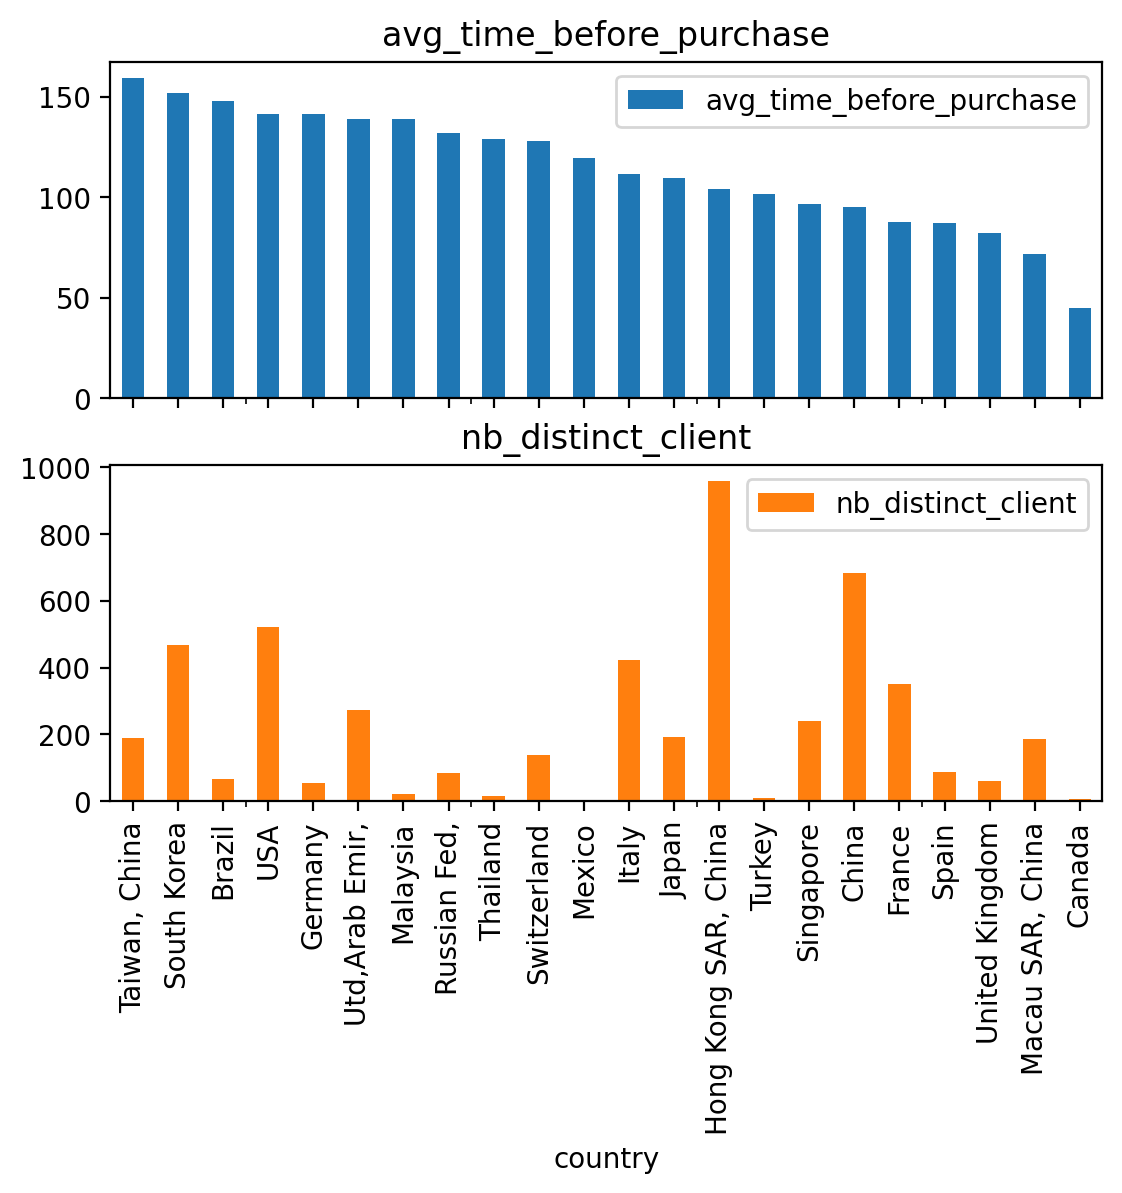

In [79]:
avg_time_before_purchase.df().plot.bar(x="country", subplots=True)